In [40]:
%matplotlib inline

import sys
import datetime
import random
import math
from pprint import pprint

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import Quandl
import numpy as np
from sklearn import linear_model as lm
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree
from sklearn.grid_search import GridSearchCV

from utils import utils as ut
from utils import quandl as ql
from utils import composite
from utils import maps
from settings import TARGET_SERIES, TARGET_INDICATOR

sns.set_style("darkgrid")

PANEL_SCORE = True
features = {}

In [41]:
import imp
imp.reload(ut)

<module 'utils.utils' from '/home/condauser/notebooks/utils/utils.py'>

In [42]:
tar = ql.load_target()
tar = ut.xs_winsorize(tar)
tar.ix['1996-11-30'] = np.nan
tar.ix['1996-12-31'] = np.nan
tar.ix['1998-05-31'] = np.nan
tar.ix['1998-06-30'] = np.nan
features['tar'] = tar

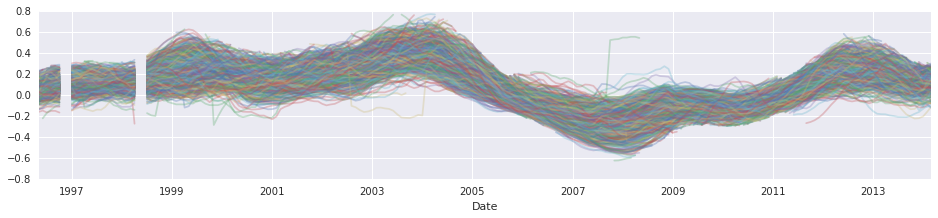

In [43]:
tar.plot(legend=False, alpha=.3, figsize=[16,3])

## increasing values

In [44]:
series = 'IV'
px, px_ca, px_us = ql.load_series(series)
print(px.shape, px.dropna().shape)
#composite.explore_series(px, px_ca, px_us, tar)
features[series] = px

(224, 724) (0, 724)


## ratio sales price to list price

In [45]:
series = 'SLPR'
px, px_ca, px_us = ql.load_series(series)
px = ut.xs_winsorize(px)
print(px.shape, px.dropna().shape)
#composite.explore_series(px, px_ca, px_us, tar)
features[series] = px

(77, 554) (0, 554)


## turnover in housing market in past year

In [46]:
series = 'SPY'
px, px_ca, px_us = ql.load_series(series)
px = ut.xs_winsorize(px)
print(px.shape, px.dropna().shape)
#composite.explore_series(px, px_ca, px_us, tar)
features[series] = px

(213, 1115) (0, 1115)


## sold for gain
- this seems to simply show that people who sold after the crisis got screwed, not sure if it adds any predictive power

In [47]:
series = 'SFG'
px, px_ca, px_us = ql.load_series(series)
print(px.shape, px.dropna().shape)
#composite.explore_series(px, px_ca, px_us, tar)

(213, 713) (9, 713)


## listings with price cuts in last 30 days

In [48]:
series = 'LPC'
px, px_ca, px_us = ql.load_series(series)
px = ut.xs_winsorize(px)
print(px.shape, px.dropna().shape)
#composite.explore_series(px, px_ca, px_us, tar)
features[series] = px

(61, 977) (0, 977)


## zillows estiamted rent - all homes
- momentum

In [52]:
# series = 'RAH'
# px, px_ca, px_us = ql.load_series(series)
# px, px_ca, px_us = ut.capped_transformation(ut.momentum, px, px_ca, px_us)
# print(px.shape, px.dropna().shape)
# composite.explore_series(px, px_ca, px_us, tar)
# features[series] = px

## median rent - homes listed for rent
- momentum

(53, 622) (0, 622)
int: 0.162231	coef: 0.029711	r2 score: 0.001590	xs corr: 0.060198


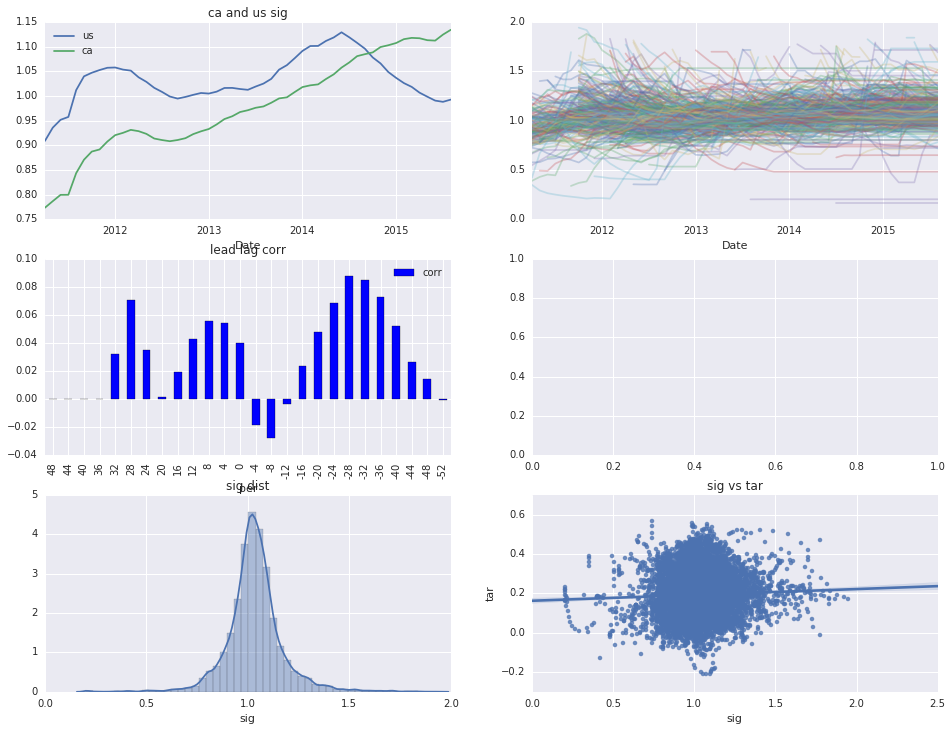

In [53]:
series = 'RMP'
px, px_ca, px_us = ql.load_series(series)
px, px_ca, px_us = ut.capped_transformation(ut.momentum, px, px_ca, px_us)
print(px.shape, px.dropna().shape)
composite.explore_series(px, px_ca, px_us, tar)
features[series] = px

## zillow's estimated median rent per square foot
- momentum

(45, 796) (0, 796)
int: 0.272710	coef: -0.075567	r2 score: 0.001380	xs corr: 0.001118


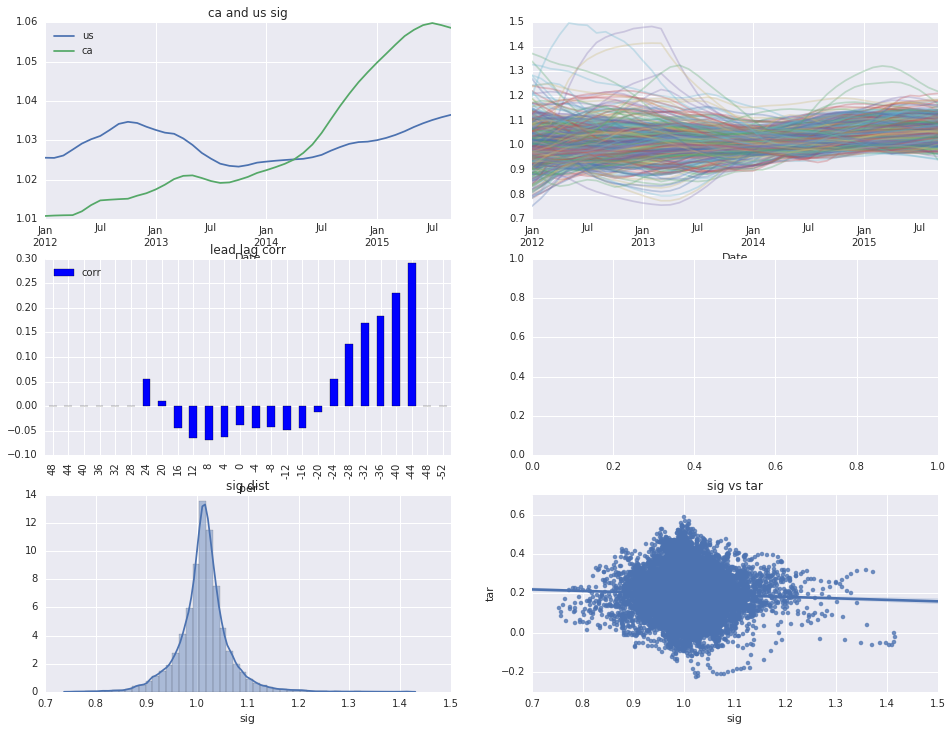

In [54]:
series = 'RZSF'
px, px_ca, px_us = ql.load_series(series)
px, px_ca, px_us = ut.capped_transformation(ut.momentum, px, px_ca, px_us)
print(px.shape, px.dropna().shape)
composite.explore_series(px, px_ca, px_us, tar)

## price to rent ratio
- momentum

(46, 741) (0, 741)
int: 0.517148	coef: -0.315550	r2 score: 0.092183	xs corr: 0.113912


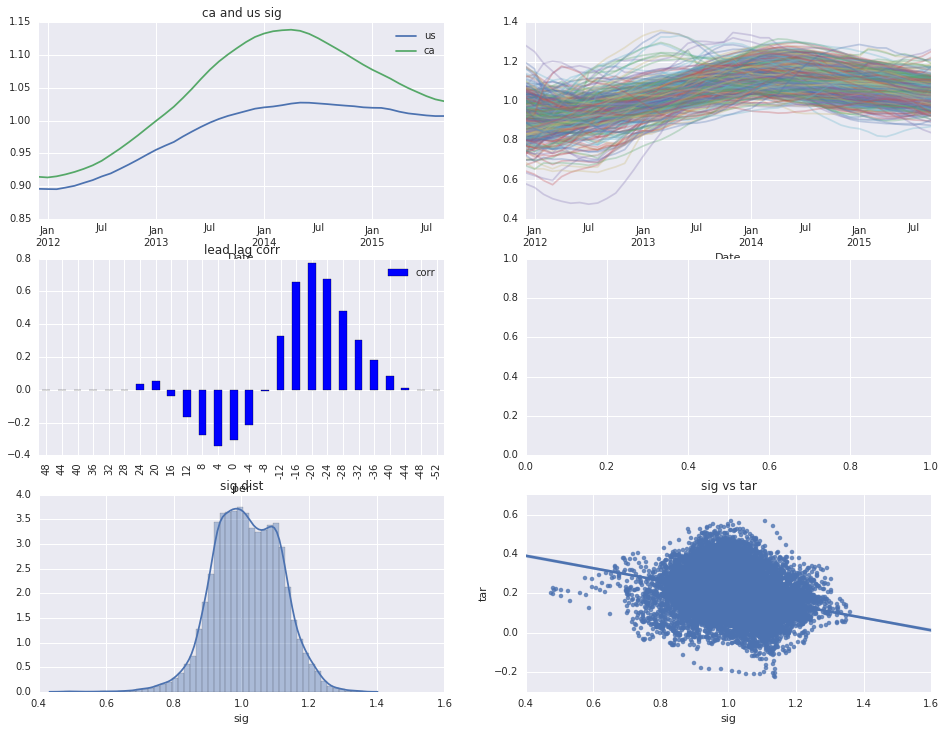

In [55]:
series = 'PRR'
px, px_ca, px_us = ql.load_series(series)
px, px_ca, px_us = ut.capped_transformation(ut.momentum, px, px_ca, px_us)
print(px.shape, px.dropna().shape)
composite.explore_series(px, px_ca, px_us, tar)
features[series] = px

## percentage sales that were foreclosures
- momentum

(199, 661) (0, 661)
int: 0.178321	coef: -0.057139	r2 score: 0.211336	xs corr: -0.192706


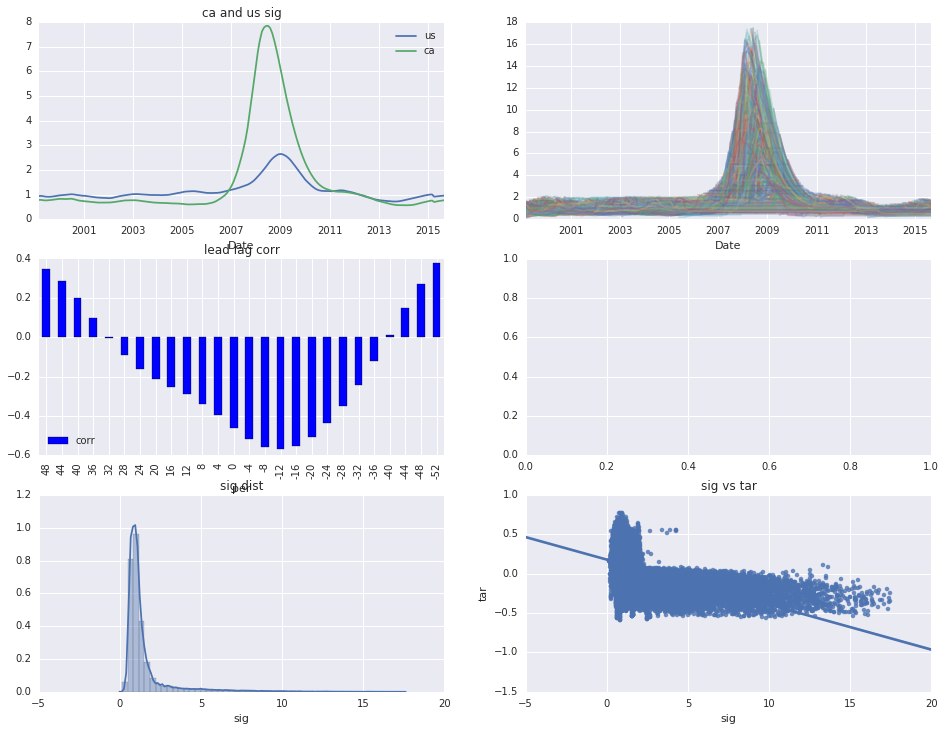

In [56]:
series = 'FR'
px, px_ca, px_us = ql.load_series(series)
px, px_ca, px_us = ut.capped_transformation(ut.momentum, px, px_ca, px_us)
print(px.shape, px.dropna().shape)
composite.explore_series(px, px_ca, px_us, tar)
features[series] = px

## number of homes for rent
- momentum

(54, 548) (0, 548)
int: 0.152688	coef: 0.022798	r2 score: 0.041129	xs corr: 0.193215


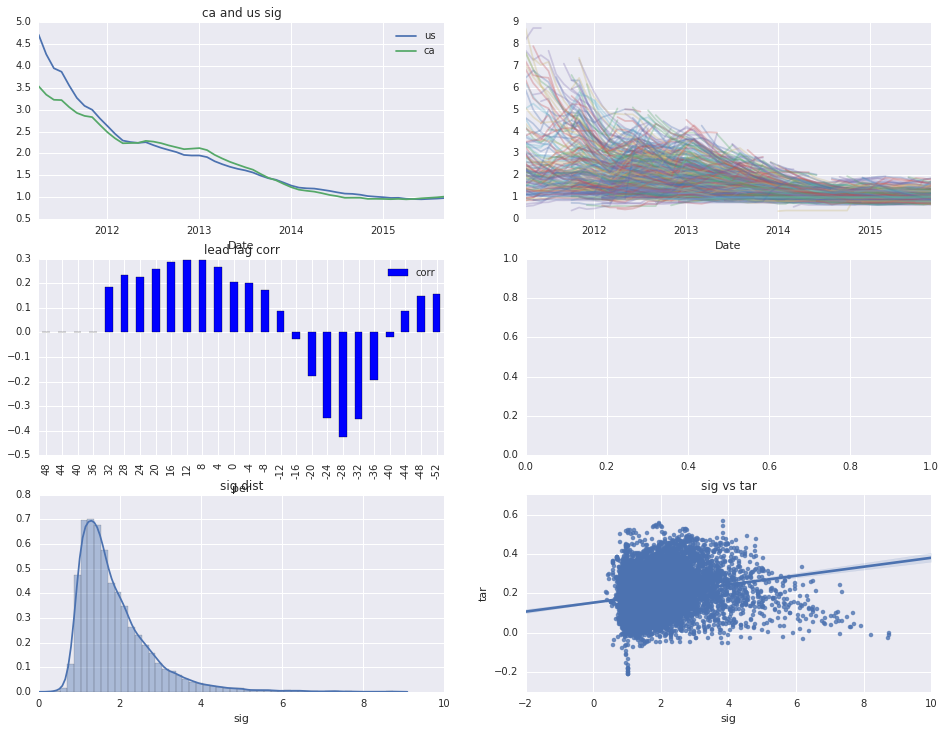

In [57]:
series = 'HR'
px, px_ca, px_us = ql.load_series(series)
px, px_ca, px_us = ut.capped_transformation(ut.momentum, px, px_ca, px_us)
print(px.shape, px.dropna().shape)
composite.explore_series(px, px_ca, px_us, tar)
features[series] = px

# prep data

In [58]:
df = ut.stack_and_align(features.values(), cols=features.keys())#.dropna()
df.index.levels[1].name = 'code'
for c in df.columns:
    print("{0}\t{1}".format(c, df[c].unstack().dropna(how='all').shape))

PRR	(46, 1120)
HR	(54, 1120)
tar	(211, 1120)
LPC	(61, 1120)
IV	(224, 1120)
SLPR	(77, 1120)
SPY	(213, 1120)
FR	(199, 1120)
RMP	(53, 1120)


In [59]:
# drop ids for which there are no target values
has_tars = df.tar.unstack().dropna(axis=1, how='all').columns.values
indexer = [slice(None)]*len(df.index.names)
indexer[df.index.names.index('code')] = has_tars
df = df.loc[tuple(indexer),:]

In [60]:
def gen_mkt_movement(df):
    px, px_ca, px_us = ql.load_series(TARGET_SERIES)

    def expand_series_change(s, per):
        s = s.div(s.shift(per))
        return pd.DataFrame(np.repeat(np.array([s.values]).T, repeats=df.ix[:,0].unstack().shape[1], axis=1),
                            columns=df.ix[:,0].unstack().columns,
                            index=s.index)
    
    short = expand_series_change(px_ca, 6)
    med = expand_series_change(px_ca, 12)
    long = expand_series_change(px_ca, 24)
    
    mkt = ut.stack_and_align([short, med, long], cols=['short', 'med', 'long'])
    return mkt.ix[df.index]

mkt = gen_mkt_movement(df)

df = df.merge(mkt, left_index=True, right_index=True)

In [61]:
df.to_csv('data/processed/raw_grouped.csv')